# **ReduceLROnPlateau (RMSprop)**

## **Importar dataset**

In [1]:
import kagglehub    # Libreria para la descarga de archivos de kaggle

# Download latest version
path = kagglehub.dataset_download("gpiosenka/railway-track-fault-detection-resized-224-x-224")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/railway-track-fault-detection-resized-224-x-224


## **Directorios**

In [2]:
# Necesitaremos la librería os, que nos permite interactuar con el sistema operativo y manipular rutas.
import os

# Directorio de entrenamiento:
train_dir = os.path.join(path, 'train')
# Directorio de pruebas:
test_dir = os.path.join(path, 'test')
# Directorio de validacion:
valid_dir = os.path.join(path, 'valid')

## **Importar modelos**

In [3]:
# Los modelos pre-entrenados se encontrarán en la librería de tensorflow.
import tensorflow as tf

# Aprovechamos para fijar la semilla y evitar la aleatoriedad entre simulaciones.
import random
import numpy as np

# Fijar semillas
Semilla = 42
os.environ['PYTHONHASHSEED'] = str(Semilla) # Controlamos la aleatoridad en el hashing de objetos.
random.seed(Semilla)                        # Controlamos la aleatoridad en la generación de números aleatorios.
np.random.seed(Semilla)                     # Controlamos la aleatoridad en la generación de números aleatorios en numpy.
tf.random.set_seed(Semilla)                 # Controlamos la aleatoridad en la generación de números aleatorios en tensorflow.

# Configurar comportamiento determinista en TensorFlow
os.environ['TF_DETERMINISTIC_OPS'] = '1'    # Configuramos una variable de entorno destinada a ciertas operaciones no deterministas como deterministas.

### VGG16

In [4]:
def modelo_base ():
  VGG16_Base = (tf.keras.applications.VGG16(include_top=False,        # Eliminamos su clasificador.
                                          weights='imagenet',         # Mantenemos los pesos de cada capa.
                                          input_shape=(224, 224, 3))) # Especificamos el tamaño de los datos de entrada.
  # Congelamos el modelo.
  for layer in VGG16_Base.layers:
    layer.trainable = False
  return VGG16_Base

## **Entrenamiento**

### Datos de entrada

In [5]:
# Importamos la clase ImageDataGenerator contenido en Keras.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [6]:
datagen = ImageDataGenerator(rescale=1./255)

# Definimos los generadores para cada uno de los conjuntos.
train_data = datagen.flow_from_directory(
    train_dir,                 # Directorio de datos original.
    batch_size=32,             # Cantidad de datos por iteración.
    class_mode='categorical',  # Tipo categórico (defectuoso y no defectuoso).
    color_mode="rgb",          # Escala de colores.
    target_size=(224, 224),    # Tamaño de los datos a la salida.
    subset='training'          # Nombre del subset originado.
)
validation_data = datagen.flow_from_directory(
    valid_dir,                 # Directorio de datos original.
    batch_size=32,             # Cantidad de datos por iteración.
    class_mode='categorical',  # Tipo categórico (defectuoso y no defectuoso).
    color_mode="rgb",          # Escala de colores.
    target_size=(224, 224),    # Tamaño de los datos a la salida.
    shuffle=False              # Mezcla de los datos.
)
test_data = datagen.flow_from_directory(
    test_dir,                  # Directorio de datos original.
    batch_size=32,             # Cantidad de datos por iteración.
    class_mode='categorical',  # Tipo categórico (defectuoso y no defectuoso).
    color_mode="rgb",          # Escala de colores.
    target_size=(224, 224),    # Tamaño de los datos a la salida.
    shuffle=False              # Mezcla de los datos.
)

Found 299 images belonging to 2 classes.
Found 62 images belonging to 2 classes.
Found 22 images belonging to 2 classes.


### Modelo VGG16

In [7]:
# Definimos el modelo base
VGG16_Base = modelo_base()

# Creamos un modelo nuevo.
VGG16_RLROP = tf.keras.Sequential()

# Introducimos primero el modelo pre-entrenado sin clasificador.
VGG16_RLROP.add(VGG16_Base)

# Añadimos el clasificador categórico.
VGG16_RLROP.add(tf.keras.layers.Flatten())
VGG16_RLROP.add(tf.keras.layers.Dense(500, activation='relu'))
VGG16_RLROP.add(tf.keras.layers.Dense(200, activation='relu'))
VGG16_RLROP.add(tf.keras.layers.Dense(2, activation='sigmoid'))

# Observamos el modelo resultante.
VGG16_RLROP.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │    12,544,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │       100,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           402 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,359,790 (104.37 MB)

 Trainable params: 12,645,102 (48.24 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [8]:
# Para realizar la simulación o entrenamiento emplearemos dos librerías.
from keras import optimizers # Contiene optimizadores, encargados de ajustar los pesos.
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,  Callback # Son algoritmos que ayudan a evitar que nuestro modelo entre en overfitting
import time

In [9]:

# La reducción de learning rate se encargará de determinar como de rápido debe aprender nuestro modelo.
rlr1 = ReduceLROnPlateau(monitor = 'val_loss', # Variable a monitorear.
                        factor = 0.1,         # Cuanto debe reducirse el lr. new_lr = lr*factor.
                        patience = 4,         # Número de épocas sin mejoras para que se reduzca el lr.
                        verbose = 0,          # Información de estado.
                        min_delta = 1e-5,     # Margen sobre el que se determina el nuevo óptimo.
                        min_lr = 1e-5,        # Learning rate minimo a alcanzar.
                        mode = 'min',         # Modo de actuación.
                        cooldown=1)           # Numero de epocas necesarias para volver a trabajar normalmente.

# Creamos la lista de callbacks.
callbacks_list1 = [rlr1]

In [10]:
# Compilamos el modelo antes definido.
VGG16_RLROP.compile(loss='categorical_crossentropy',
                optimizer=optimizers.RMSprop(),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG16_RLROP_start_time = time.time()
VGG16_RLROP_history = VGG16_RLROP.fit(
    train_data,
    epochs=20,
    validation_data=validation_data,
    callbacks=callbacks_list1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 451ms/step - acc: 0.5139 - loss: 13.1254 - val_acc: 0.5000 - val_loss: 2.5285 - learning_rate: 0.0010
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step - acc: 0.4782 - loss: 2.5936 - val_acc: 0.5968 - val_loss: 1.0369 - learning_rate: 0.0010
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - acc: 0.6480 - loss: 0.8856 - val_acc: 0.7903 - val_loss: 0.4846 - learning_rate: 0.0010
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step - acc: 0.6408 - loss: 0.8082 - val_acc: 0.7097 - val_loss: 0.5560 - learning_rate: 0.0010
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 279ms/step - acc: 0.7270 - loss: 0.6145 - val_acc: 0.5806 - val_loss: 0.7537 - learning_rate: 0.0010
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 267ms/step - acc: 0.7908 - loss: 0.4073 - val_acc: 0.6129 - val_loss: 0.7061 - learning_rate: 0.0010
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 242ms/step - acc: 0.7330 - loss: 0.4817 - val_acc: 0.8226 - val_loss: 0.3889 - learning_rate: 0.0010
Epoch

In [11]:
# Obtenemos los parametros de interes de la simulacion.
VGG16_RLROP_acc1 = VGG16_RLROP_history.history['acc']
VGG16_RLROP_val_acc1 = VGG16_RLROP_history.history['val_acc']
VGG16_RLROP_loss1 = VGG16_RLROP_history.history['loss']
VGG16_RLROP_val_loss1 = VGG16_RLROP_history.history['val_loss']

In [12]:
# Ahora descongelamos las últimas capas y volvemos a simular.
for layer in VGG16_Base.layers[-2:]:
    layer.trainable = True

# Compilamos nuevamente el modelo
VGG16_RLROP.compile(loss='categorical_crossentropy',
                optimizer=optimizers.RMSprop(),
                metrics=['acc'])

# Realizamos el entrenamiento.
VGG16_RLROP_history = VGG16_RLROP.fit(
    train_data,
    epochs=20,
    validation_data=validation_data,
    callbacks=callbacks_list1)
VGG16_RLROP_end_time = time.time()
print(f"Tiempo de ejecución: {VGG16_RLROP_end_time - VGG16_RLROP_start_time} segundos")

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 326ms/step - acc: 0.6280 - loss: 5.9073 - val_acc: 0.5000 - val_loss: 0.8423 - learning_rate: 0.0010
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step - acc: 0.6272 - loss: 0.6057 - val_acc: 0.7419 - val_loss: 0.4897 - learning_rate: 0.0010
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 272ms/step - acc: 0.8686 - loss: 0.3247 - val_acc: 0.8065 - val_loss: 0.4528 - learning_rate: 0.0010
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 288ms/step - acc: 0.8994 - loss: 0.3072 - val_acc: 0.7742 - val_loss: 0.7394 - learning_rate: 0.0010
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 271ms/step - acc: 0.7831 - loss: 0.7336 - val_acc: 0.6452 - val_loss: 1.7325 - learning_rate: 0.0010
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 275ms/step - acc: 0.8589 - loss: 0.3549 - val_acc: 0.8548 - val_loss: 0.4320 - learning_rate: 0.0010
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 272ms/step - acc: 0.9920 - loss: 0.0253 - val_acc: 0.6290 - val_loss: 1.7680 - learning_rate: 0.0010
Epoch 

In [13]:
# Obtenemos los parametros de interes de la simulacion.
VGG16_RLROP_acc2 = VGG16_RLROP_history.history['acc']
VGG16_RLROP_val_acc2 = VGG16_RLROP_history.history['val_acc']
VGG16_RLROP_loss2 = VGG16_RLROP_history.history['loss']
VGG16_RLROP_val_loss2 = VGG16_RLROP_history.history['val_loss']

### Representación gráfica

#### Precisión de validación

In [14]:
# Importamos la librería matplotlib para la representación gráfica de los resultados.
import matplotlib.pyplot as plt

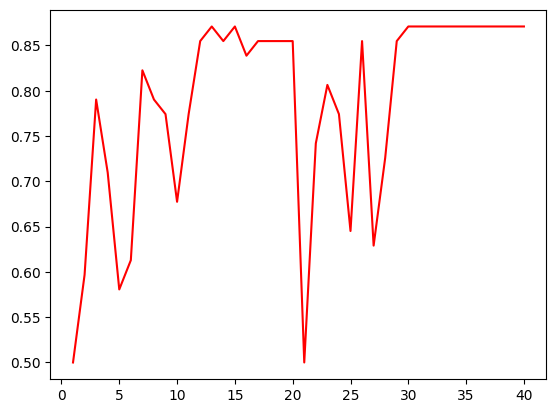

In [15]:
# Epocas del eje X
VGG16_RLROP_val_acc = VGG16_RLROP_val_acc1 + VGG16_RLROP_val_acc2
epochs = range(1, len(VGG16_RLROP_val_acc) + 1)

# Representamos las gráficas
plt.plot(epochs, VGG16_RLROP_val_acc, 'r')

# Mostrar la figura
plt.show()

### Matriz de confusión

In [16]:
# Look at confusion matrix
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, ["Defective", "Non-Defective"])
    plt.yticks(tick_marks, ["Defective", "Non-Defective"], rotation=45)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.mean()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Observación')
    plt.xlabel('Predicción')

In [17]:
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 525ms/step


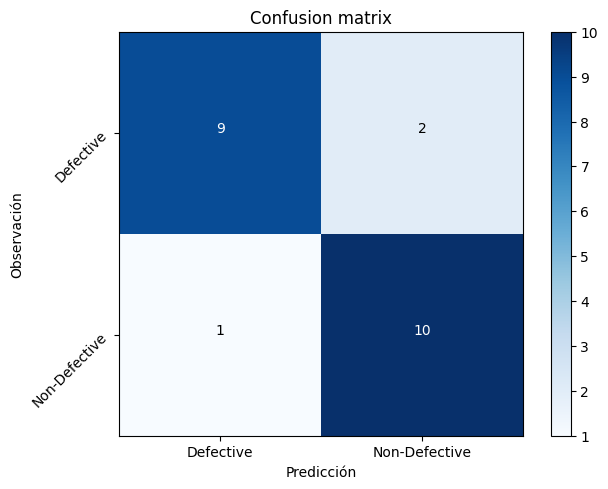

In [18]:
# Predict the values from the validation dataset
Y_pred = VGG16_RLROP.predict(test_data)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred, axis=1)
# Convert validation observations to one hot vectors
Y_true = test_data.classes
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))

### Curva ROC

In [19]:
from sklearn.metrics import roc_curve, auc

In [20]:
def plot_roc_curve(fpr, tpr):
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color="red", label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="green", linestyle="--", label="Random classifier")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


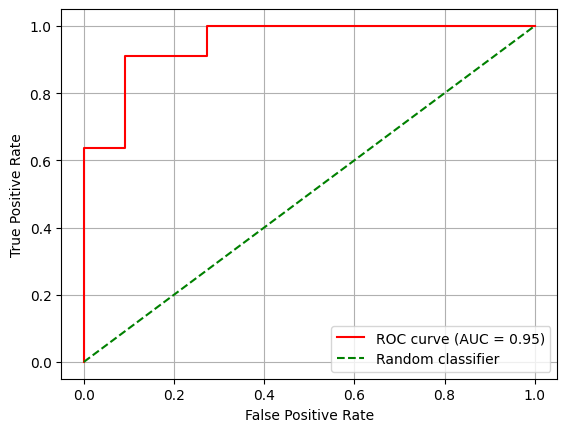

In [21]:
Y_pred = VGG16_RLROP.predict(test_data)
Y_true = test_data.classes
Y_pred_probs = Y_pred[:, 1]  # Probabilidad de la clase positiva

fpr, tpr, thresholds = roc_curve(Y_true, Y_pred_probs)
plot_roc_curve(fpr, tpr)